In [1]:
import json

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "png"
pio.templates.default = "plotly_white"

from pathlib import Path

In [2]:
BASEDIR = "../output"
RUN_ID = "ded9097f-3920-4632-8730-b9d953cbbc72"

In [3]:
metadata_file =  Path(BASEDIR).joinpath(RUN_ID + "_meta.json")
metrics_file =  Path(BASEDIR).joinpath(RUN_ID + "_metrics.json")

In [4]:
with open(metadata_file) as f:
    metadata = json.load(f)

print(f"""Run "{metadata["run_id"]}"
    Algorithm: {metadata["algorithm"]}
    Dataset: {metadata["dataset"]}
    Model: {metadata["model"]}
    {metadata["rounds"]} rounds with {metadata["epochs"]} epochs each""")

Run "ded9097f-3920-4632-8730-b9d953cbbc72"
    Algorithm: FedAvg
    Dataset: MNIST
    Model: CNN
    30 rounds with 5 epochs each


In [5]:
def expand_json_column(df: pd.DataFrame, column: str) -> pd.DataFrame:
    return pd.concat((df, pd.json_normalize(df[column])), axis=1).drop(columns=column)

In [6]:
run_metrics = pd.read_json(metrics_file, lines=True)

run_metrics = expand_json_column(run_metrics, "metrics")
run_metrics["client_id"] = run_metrics["client_id"].astype(pd.Int64Dtype())
run_metrics["epoch"] = run_metrics["epoch"].astype(pd.Int64Dtype())
run_metrics = run_metrics.melt(id_vars=["timestamp", "log_type", "stage", "client_id", "round", "epoch"], value_vars=["loss", "accuracy"], var_name="metric_name", value_name="metric_value")

run_metrics.head()

,timestamp,log_type,stage,client_id,round,epoch,metric_name,metric_value
0,2023-10-13 13:35:23.180503,client,train,59,1,0,loss,2.292723
1,2023-10-13 13:35:23.262390,client,train,59,1,1,loss,2.288160
2,2023-10-13 13:35:23.344882,client,train,59,1,2,loss,2.284074
3,2023-10-13 13:35:23.424594,client,train,59,1,3,loss,2.277774
4,2023-10-13 13:35:23.506894,client,train,59,1,4,loss,2.276298


In [7]:
client_metrics = run_metrics.query("log_type == 'client'").copy()
client_metrics["step"] = client_metrics["round"] * 100
client_metrics["step"] += client_metrics["epoch"]
server_metrics = run_metrics.query("log_type == 'server'")
del run_metrics

# Server Metrics

In [8]:
server_losses = server_metrics.query("metric_name == 'loss'")
server_accuracies = server_metrics.query("metric_name == 'accuracy'")

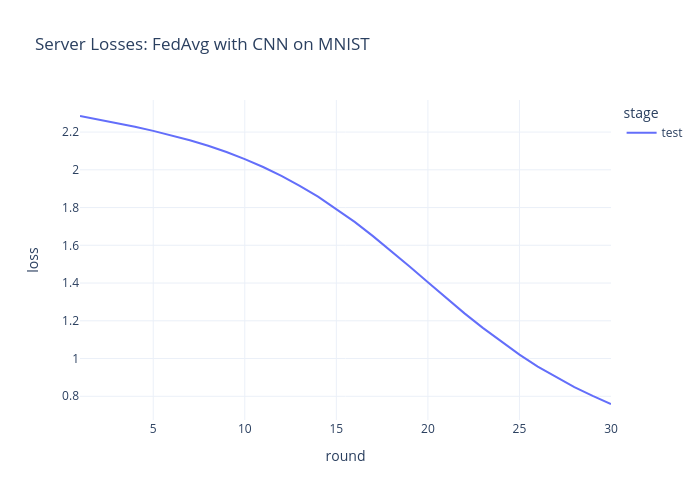

In [18]:
px.line(server_losses, x="round", y="metric_value", color="stage", labels={"metric_value": "loss"},\
        title=f"""Server Losses: {metadata["algorithm"]} with {metadata["model"]} on {metadata["dataset"]}""")

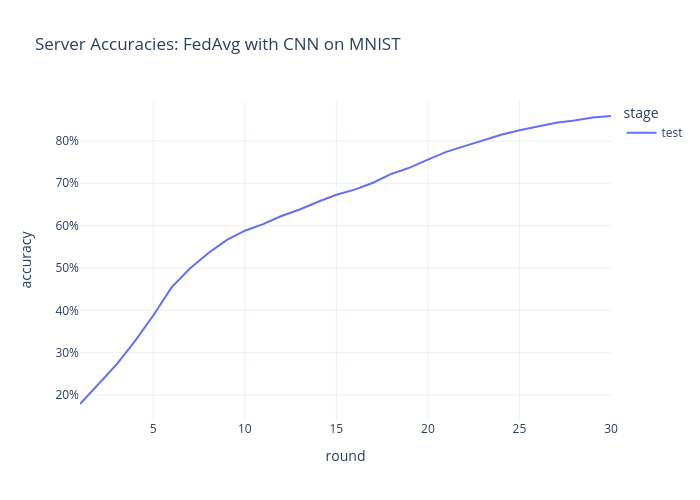

In [19]:
fig = px.line(server_accuracies, x="round", y="metric_value", color="stage", labels={"metric_value": "accuracy"},\
              title=f"""Server Accuracies: {metadata["algorithm"]} with {metadata["model"]} on {metadata["dataset"]}""")
fig.update_layout(yaxis_tickformat = ".0%")
fig

# Client Metrics

In [21]:
client_losses = client_metrics.query("metric_name == 'loss'")
client_accuracies = client_metrics.query("metric_name == 'accuracy'")

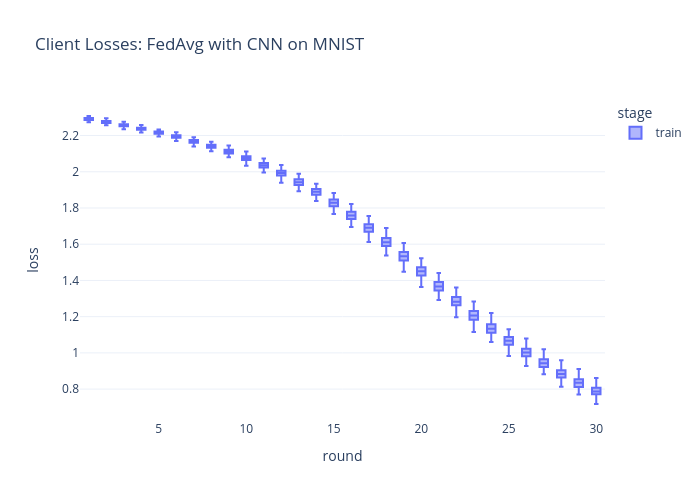

In [24]:
px.box(client_losses, x="round", y="metric_value", color="stage", labels={"metric_value": "loss"},\
        title=f"""Client Losses: {metadata["algorithm"]} with {metadata["model"]} on {metadata["dataset"]}""")

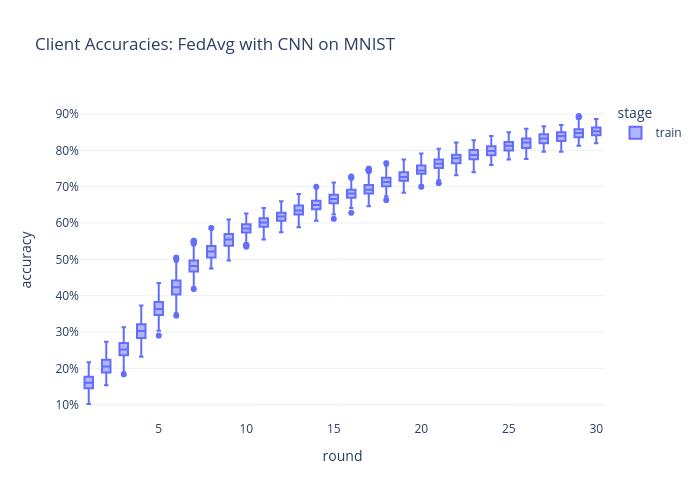

In [25]:
fig = px.box(client_accuracies, x="round", y="metric_value", color="stage", labels={"metric_value": "accuracy"}, \
              title=f"""Client Accuracies: {metadata["algorithm"]} with {metadata["model"]} on {metadata["dataset"]}""")
fig.update_layout(yaxis_tickformat=".0%")
fig